<img src="assets/screenshot_ndbc.png" style="width:100%" />

# NDBC demo

This notebook shows examples of interacting with NDBC near real time wave spectra usint the Datamesh [python client](https://oceanum-python.readthedocs.org/).

## Required python libraries

- oceanum
- matplotlib
- cartopy
- xarray
- pandas
- geopandas
- wavespectra

In [49]:
import os
import geopandas
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from wavespectra import read_dataset
from tqdm import tqdm
from datetime import datetime, timedelta

from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

## 1. Datamesh connector

Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [2]:
datamesh = Connector(token=None)

## 2. Search for the datasources

Search for the NDBC near real time buoy data in Datamesh using the [get_catalog](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html#oceanum.datamesh.Connector.get_catalog) method which returns a catalog with all datasources matching the searching criteria

In [3]:
cat_ndbc = datamesh.get_catalog("ndbc nrt")
print(len(cat_ndbc))
list(cat_ndbc)[:3]

200


[
         NDBC near real time spectra site 41001 [ndbc_nrt_spectra_41001]
             Extent: (-72.19599914550781, 34.750999450683594, -72.19599914550781, 34.750999450683594)
             Timerange: 2022-03-02 20:50:00+00:00 to None
         ,
 
         NDBC near real time spectra site 41010 [ndbc_nrt_spectra_41010]
             Extent: (-78.49299621582031, 28.871999740600586, -78.49299621582031, 28.871999740600586)
             Timerange: 2018-02-28 06:00:00+00:00 to None
         ,
 
         NDBC near real time spectra site 41043 [ndbc_nrt_spectra_41043]
             Extent: (-64.96600341796875, 21.06100082397461, -64.96600341796875, 21.06100082397461)
             Timerange: 2012-10-01 00:00:00+00:00 to None
         ]

Each entry in the catalog is a Datamesh [Datasource](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Datasource.html#oceanum.datamesh.Datasource) object which holds a number of attributes defining the data such as `variables`, `coordinates`, `schema`, `tstart`, `tend` and others. Datasource instances can also be directly created from the datasource ID using the `get_datasource` method:

In [4]:
ds = datamesh.get_datasource("ndbc_nrt_spectra_41001")
ds


        NDBC near real time spectra site 41001 [ndbc_nrt_spectra_41001]
            Extent: (-72.19599914550781, 34.750999450683594, -72.19599914550781, 34.750999450683594)
            Timerange: 2022-03-02 20:50:00+00:00 to None
            8 attributes
            5 variables
        

In [5]:
ds.description

'Near real time wave spectra from NOAA National Data Buoy Center and Participators in Data Assembly Center'

In [6]:
ds.tstart

datetime.datetime(2022, 3, 2, 20, 50, tzinfo=TzInfo(UTC))

In [7]:
ds.variables.keys()

dict_keys(['mean_wave_dir', 'wave_spectrum_r1', 'wave_spectrum_r2', 'principal_wave_dir', 'spectral_wave_density'])

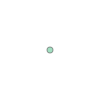

In [8]:
ds.geom

### 2.1. Retrieve and plot the locations of all buoys

In [9]:
TRANSFORM = ccrs.PlateCarree()

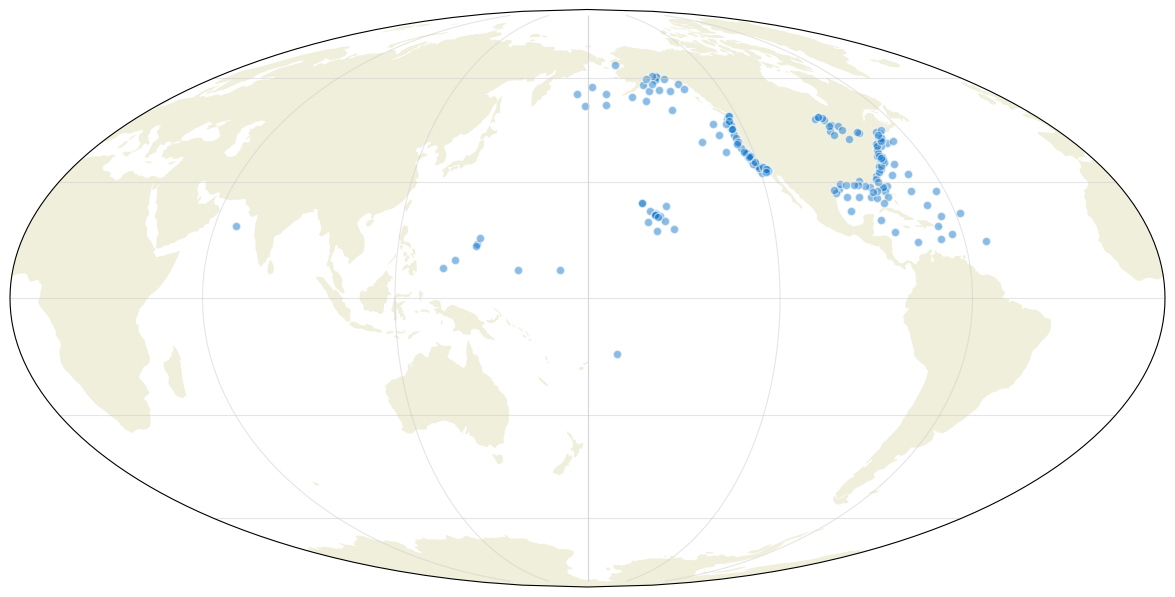

In [28]:
projection = ccrs.Mollweide(central_longitude=180)

xb = [ds.geom.x for ds in list(cat_ndbc)]
yb = [ds.geom.y for ds in list(cat_ndbc)]

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))
ax.set_global()
ax.plot(xb, yb, "wo", markerfacecolor="#187bcd", alpha=0.5, transform=TRANSFORM)
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

## 3. Compare against the Oceanum Northwest America hindcast

The Oceanum SWAN Northwest America hindcast is defined by three SWAN nests with resolutions of 10 km, 2 km and 500 m. Here we will work with data from the 2 km nest which covers part of California and Baja California coasts

### 3.1 Identify the hindcast data

#### Search for the California 2km hindcast datasources

In [13]:
cat_hds = datamesh.get_catalog("swan california")
list(cat_hds)

[
         Oceanum California 2km wave hindcast spectra [oceanum_wave_cali_era5_spec]
             Extent: (-120.9000015258789, 31.399999618530273, -116.5999984741211, 34.70000076293945)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-06-01 00:00:00+00:00
         ,
 
         Oceanum California 2km wave hindcast parameters [oceanum_wave_cali_era5_grid]
             Extent: (-121.0, 31.299999237060547, -116.4000015258789, 34.79999923706055)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-06-01 00:00:00+00:00
         ,
 
         Oceanum SW North America 10km wave hindcast spectra [oceanum_wave_swna_era5_spec]
             Extent: (-121.0, 31.299999237060547, -116.4000015258789, 34.79999923706055)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-06-01 00:00:00+00:00
         ,
 
         Oceanum SW North America 10km wave hindcast parameters [oceanum_wave_swna_era5_grid]
             Extent: (-124.0, 30.0, -115.5, 36.0)
             Timerange: 1979-02-01 00

#### Get the boundary geometry from the California 2 km spectra datasource

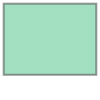

In [14]:
ds_hds = datamesh.get_datasource("oceanum_wave_cali_era5_spec")
x0, y0, x1, y1 = ds_hds.bounds
ds_hds.geom

#### Query a grid snapshot from the California 2 km parameters datasource for plotting

In [15]:
query = {
    "datasource": "oceanum_wave_cali_era5_grid",
    "variables": ["hs", "depth"],
    "timefilter": {"type": "range", "times": ["20240101T00", "20240101T00"]},
}
cali = datamesh.query(query).squeeze()
cali

<xarray.Dataset>
Dimensions:    (latitude: 176, longitude: 231)
Coordinates:
  * latitude   (latitude) float32 31.3 31.32 31.34 31.36 ... 34.76 34.78 34.8
  * longitude  (longitude) float32 -121.0 -121.0 -121.0 ... -116.4 -116.4 -116.4
    time       datetime64[ns] 2024-01-01
Data variables:
    hs         (latitude, longitude) float32 2.939 2.94 2.942 ... nan nan nan
    depth      (latitude, longitude) float32 4.057e+03 3.969e+03 ... nan nan
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 California 2km
    run:                     cali
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           326884

#### Query the coordinates of all output spectra sites from the California 2 km spectra datasource

In [17]:
query = {
    "datasource": "oceanum_wave_cali_era5_spec",
    "variables": ["lon", "lat"],
}
coords = datamesh.query(query)
coords

<xarray.Dataset>
Dimensions:  (site: 626)
Coordinates:
    lon      (site) float32 -120.8 -120.8 -120.8 -120.8 ... -116.7 -116.7 -116.6
    lat      (site) float32 31.5 31.7 31.9 32.1 32.3 ... 31.4 31.5 31.8 31.4
  * site     (site) int64 1 2 3 4 5 6 7 8 9 ... 619 620 621 622 623 624 625 626
Data variables:
    *empty*
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 California 2km
    run:                     cali
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           10016

### 3.2. Select buoys inside the hindcast domain

#### Use the geometry from the California 2 km spectra datasource to select the intersecting NDBC stations

In [18]:
datasources = [ds for ds in list(cat_ndbc) if ds_hds.geom.contains(ds.geom)]
len(datasources)

25

#### Plotting to show the data

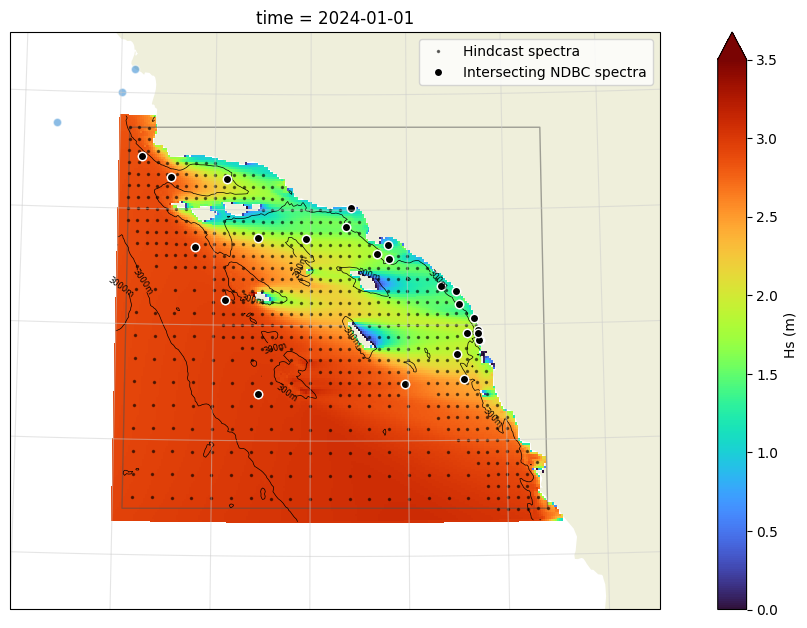

In [30]:
projection = ccrs.TransverseMercator(central_longitude=float(x1 + x0) / 2)

xbcali = [ds.geom.x for ds in datasources]
ybcali = [ds.geom.y for ds in datasources]

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))

# Show hindcast grid snapshot
cali.hs.plot(ax=ax, cmap="turbo", vmin=0, vmax=3.5, cbar_kwargs=dict(label="Hs (m)"), transform=TRANSFORM)
c = cali.depth.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=TRANSFORM)
c.clabel(fmt="%0.0fm", fontsize=6)

# Show the hindcast spectra locations
ax.plot(coords.lon, coords.lat, ".", markersize=3, color="0.0", alpha=0.5, transform=TRANSFORM, label="Hindcast spectra")

# Show the buoy locations
ax.plot(xb, yb, "wo", markerfacecolor="#187bcd", alpha=0.5, transform=TRANSFORM)
ax.plot(xbcali, ybcali, "wo", markerfacecolor="k", alpha=1.0, transform=TRANSFORM, label="Intersecting NDBC spectra")

# Show the land mask
ax.add_feature(cfeature.LAND)

# Show spectra dataset bounds
geopandas.GeoSeries(ds_hds.geom).plot(ax=ax, facecolor="none", edgecolor="0.3", alpha=0.5, transform=TRANSFORM)

ax.legend(loc=1)
ax.set_extent([-122.0, -115.5, 30.5, 35.5])
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

### 3.3. Query and analyse spectra

Query spectra from the California 2 km hindcast and from intersecting NDBC buoys. Calculate integrated wave parameters using the [wavespectra](https://github.com/wavespectra/wavespectra) library to compare

#### Functions to read and colocate the data

In [31]:
def query_ndbc(datasource, t0=None, t1=None) -> xr.Dataset:
    """Query 1D NDBC buoy data and convert to wavespectra format to easily calculate spectral parametes."""
    query = {
        "datasource": datasource,
        "variables": ["spectral_wave_density"],
        "timefilter": {"type": "range", "times": [t0, t1]},
    }
    return datamesh.query(query).squeeze()


def query_hds(dset_ndbc, datasource="oceanum_wave_cali_era5_spec") -> xr.Dataset:
    """Query hindcast timeseries at the location and times of an NDBC buoy dataset."""
    t0, t1 = dset_ndbc.time.to_index().to_pydatetime()[[0, -1]]
    
    query = {
        "datasource": datasource,
        "timefilter": {"type": "range", "times": [t0, t1]},
        "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [[float(dset_ndbc.longitude), float(dset_ndbc.latitude)]],
                },
            },
        },
    }
    return datamesh.query(query).squeeze()


def get_colocs(datasource, stats=["hs", "tp"], t0=None, t1=None) -> pd.DataFrame:
    """Read and colocate data obs and hindcast data.

    Parameters
    ----------
    datasource (str)
        Datamesh datasource id of the NDBC spectra station.
    stats (list):
        Integrated parameters to calculate with wavespectra.
    t0 (str):
        Start time to query time series from.
    t1 (str):
        End time to query timeseries until.

    Return
    ------
    df (pd.DataFrame)
        Colocations of integrated wave parameters from obs and hindcast.

    """
    # Read the data
    dset_obs = query_ndbc(datasource, t0, t1).chunk(time=8192)
    dset_hds = query_hds(dset_obs).chunk(time=8192)

    # Convert to wavespectra convention
    dset_obs = read_dataset(dset_obs, directional=False)

    # Calculate integrated parameters and resample
    df_obs = dset_obs.spec.stats(stats).to_pandas().resample("1h").mean()
    df_hds = dset_hds.spec.stats(stats).to_pandas().resample("1h").mean()

    # Make colocs
    df = pd.concat([df_obs[stats], df_hds[stats]], axis=1).dropna()
    df.columns = [f"{v}_obs" for v in stats] + [f"{v}_hds" for v in stats]
    df["lon_obs"] = df_obs.longitude
    df["lat_obs"] = df_obs.latitude
    df["lon_hds"] = df_hds.lon
    df["lat_hds"] = df_hds.lat

    return df

#### Functions to analyse the data

In [83]:
def nsamp(df: pd.DataFrame):
    """Number of colocations."""
    return df.dropna().shape[0]


def mad(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Mean absolute difference MAD."""
    return (df[y] - df[x]).abs().mean()


def rmsd(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Root-mean-square difference RMSD."""
    return np.sqrt(((df[y] - df[x])**2).mean())


def bias(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Bias."""
    return (df[y] - df[x]).mean()


def si(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Scatter Index."""
    return np.sqrt((((df[y] - df[x]) - bias(df, x, y))**2).mean() ) / df[x].mean()


def errors(df, x: str = "hs_obs", y: str = "hs_hds"):
    """Return a label with error summary for plotting."""
    return f"Bias: {bias(df, x, y):0.2f} m\nMAD: {mad(df, x, y):0.2f} m\nRMSD: {rmsd(df, x, y):0.2f} m\nSI: {si(df, x, y):0.2f}\nN: {nsamp(df):0.0f}"

#### Functions to plot the data

In [47]:
def plot_map(df, datasource_id, ax):
    """Plot map showing the location at the NDBC datasource."""

    # Bathy contour
    c = cali.depth.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=TRANSFORM)
    c.clabel(fmt="%0.0fm", fontsize=6)

    # Buoy location
    ax.plot(xb, yb, "o", color="#187bcd", alpha=0.3, markersize=5, transform=TRANSFORM)
    ax.plot(df.lon_obs, df.lat_obs, "o", color="#187bcd", markersize=5, alpha=0.7, transform=TRANSFORM, label="NDBC")
    ax.plot(df.lon_hds, df.lat_hds, "o", color="#d84418", markersize=5, alpha=0.7, transform=TRANSFORM, label="Hindcast")
    ax.legend(loc=1)

    # Show features
    ax.add_feature(cfeature.LAND.with_scale("10m"))
    geopandas.GeoSeries(ds_hds.geom).plot(ax=ax, facecolor="none", edgecolor="0.3", alpha=0.5, transform=TRANSFORM)

    # Axis settings
    buff = 0.1
    ax.set_extent([x0-buff, x1+buff, y0-buff, y1+buff])
    ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);
    ax.set_title(f"{datasource_id.upper().replace('_', ' ')}")

    return ax


def plot_scatter(df, ax, x="hs_obs", y="hs_hds", c="tp_obs"):
    """Plot scatter of obs and hindcast."""

    # Set xlim
    xmax = df[[x, y]].max().max() * 1.1
    xlim = ylim = [0, xmax]

    # Scatter points
    p = ax.scatter(df[x], df[y], s=5, c="#187bcd", vmin=0, vmax=20, alpha=0.5, cmap="turbo")

    # Calculate and plot quantiles
    dfq = df[[x, y]].quantile(q=np.arange(0, 1.01, 0.01))
    ax.plot(dfq[x], dfq[y], "ok")

    # Equality line
    ax.plot(xlim, ylim, "--", color="0.5")

    # Show error statistics
    ax.annotate(errors(df, x, y), xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, color="0.0", bbox=dict(facecolor="0.9"))

    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Hs NDBc (m)")
    ax.set_ylabel("Hs hindcast (m)");

    return ax


def plot_data(df, datasource_id, fac=0.7):
    """Plot map with station locations and scatter of obs and hindcast."""

    fig = plt.figure(figsize=(10*fac, 18*fac))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.0, 1.0])

    # Map
    projection = ccrs.TransverseMercator(central_longitude=float(x0 + x1)/2)
    ax = plt.subplot(gs[0], projection=projection)
    ax = plot_map(df, datasource_id, ax)

    # Scatter
    ax = plt.subplot(gs[1])
    ax = plot_scatter(df, ax, x="hs_obs", y="hs_hds", c="tp_obs")

    fig.tight_layout()
    return fig

#### Compare the last year at few selected locations

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:38<00:00, 55.79s/it]


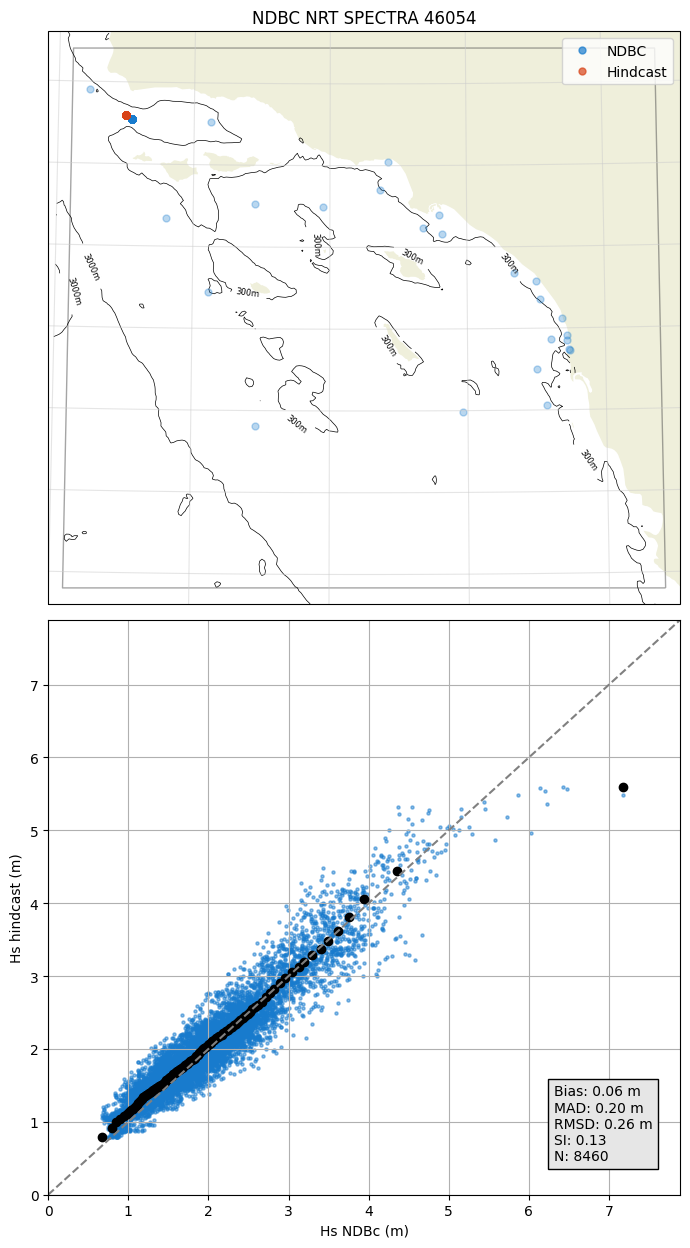

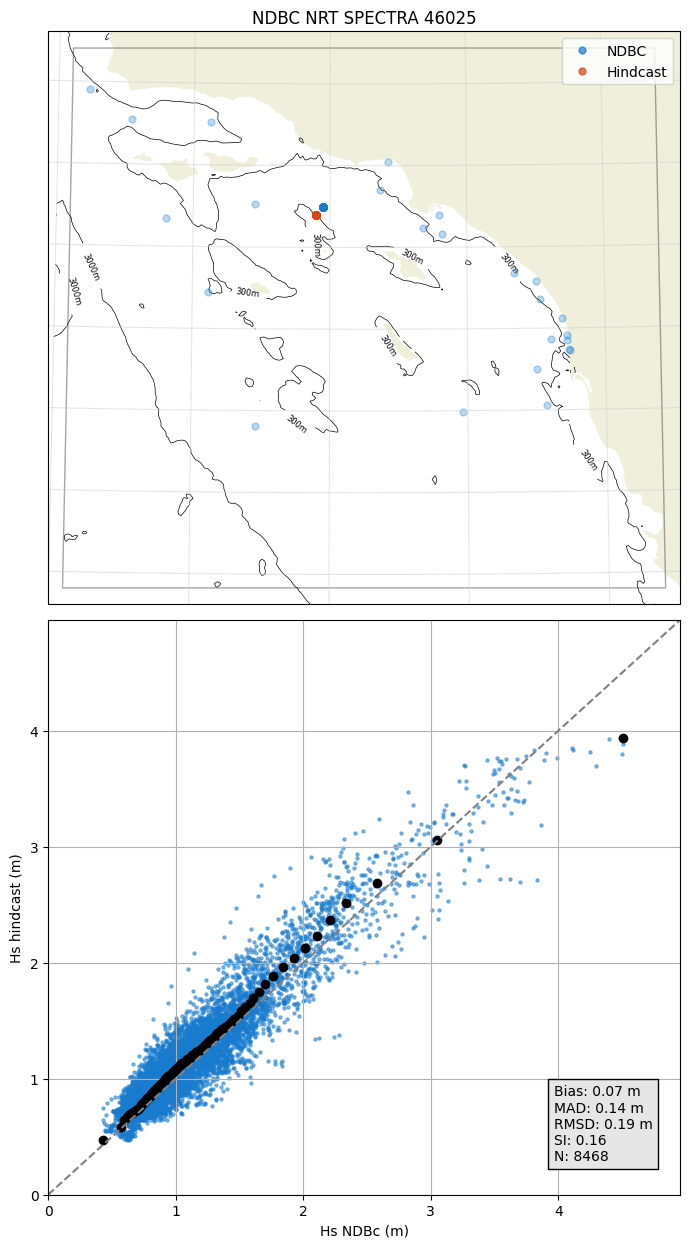

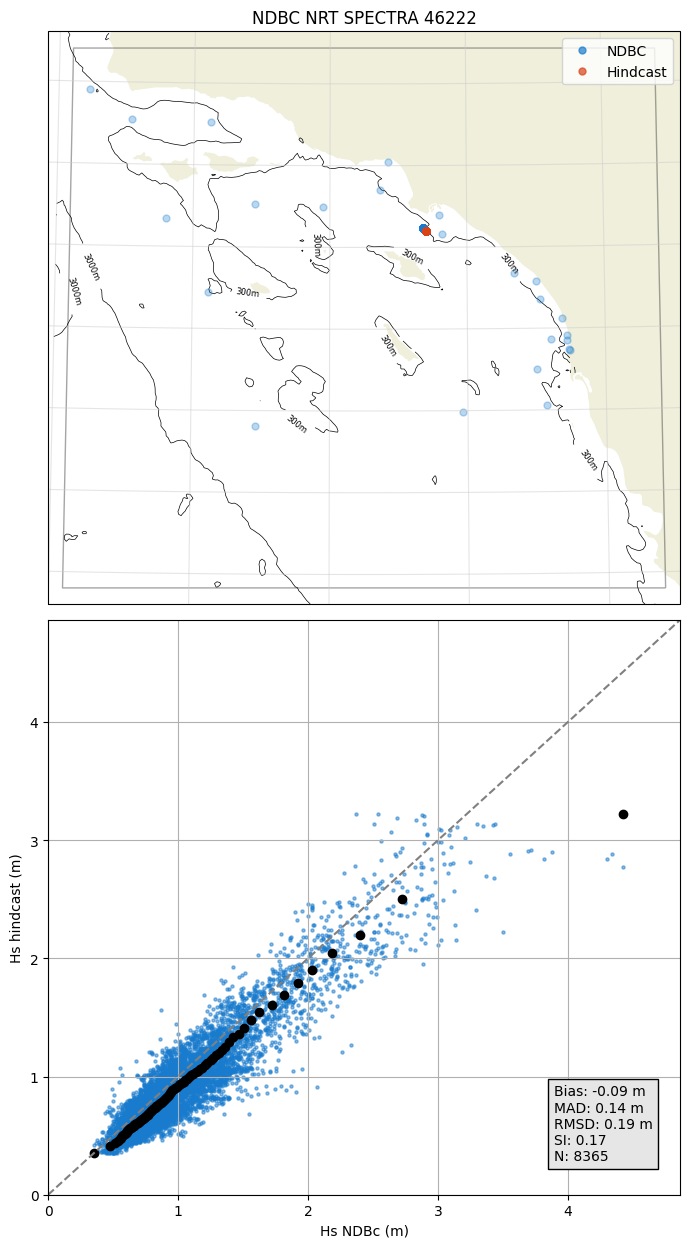

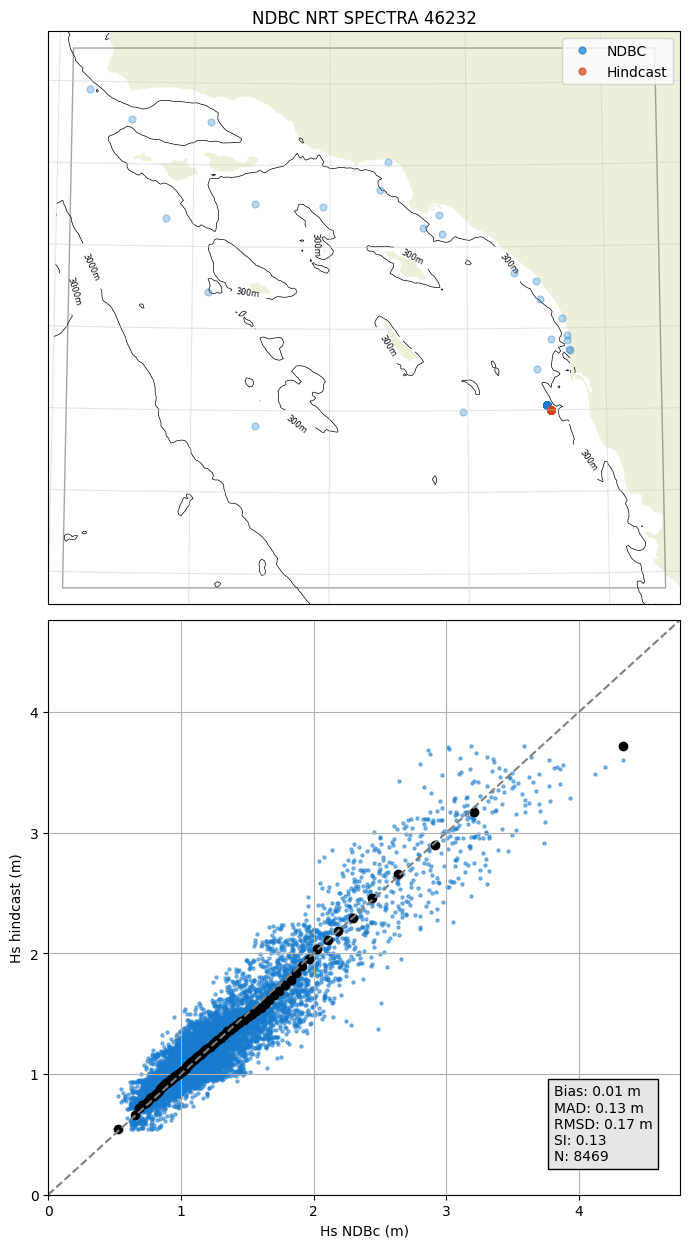

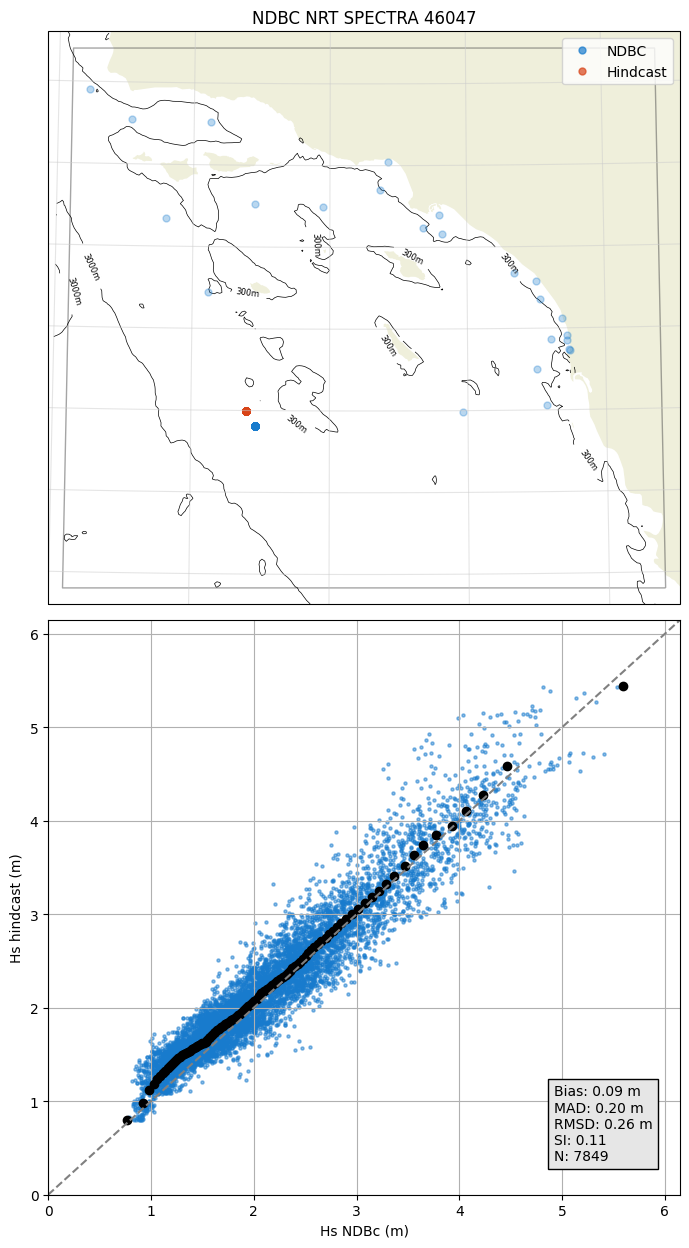

In [52]:
t0 = datetime.now() - timedelta(days=365)

selected_stations = ["46054", "46025", "46222", "46232", "46047"]

data = {}
for station in tqdm(selected_stations):
    datasource = f"ndbc_nrt_spectra_{station}"
    df = get_colocs(datasource, t0=t0)
    data.update({station: df})
    fig = plot_data(df, datasource)


#### Visualise the timeseries

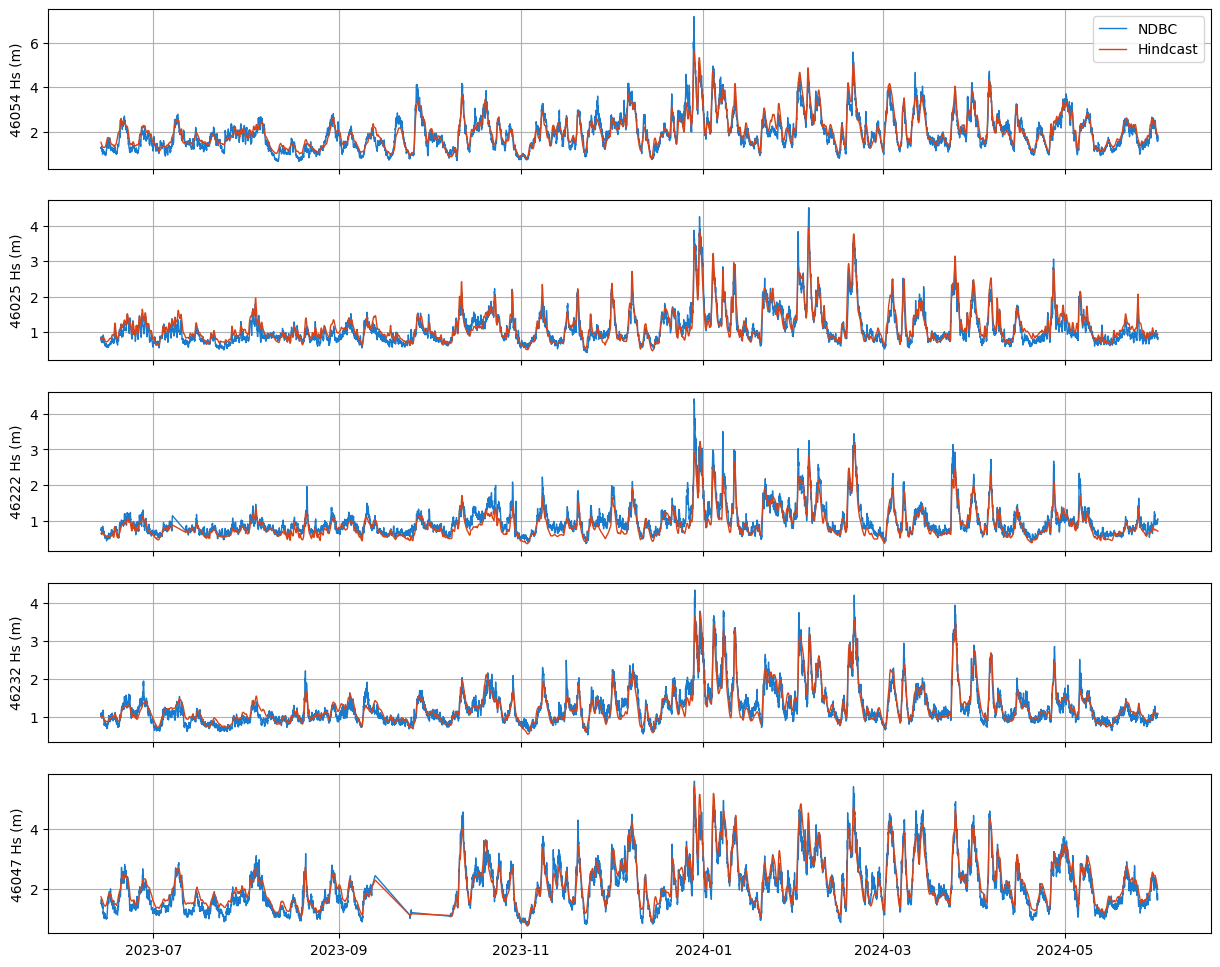

In [54]:
n = len(data)

fig, axs = plt.subplots(n, 1, figsize=(15, 12))

for ind, (station, df) in enumerate(data.items()):
    ax = axs[ind]
    ax.plot(df.index, df.hs_obs, linewidth=1.0, color="#187bcd", label="NDBC")
    ax.plot(df.index, df.hs_hds, linewidth=1.0, color="#d84418", label="Hindcast")
    ax.set_ylabel(f"{station} Hs (m)")
    ax.grid()
    if ind < len(data) - 1:
        ax.set_xticklabels("")
    if ind == 0:
        ax.legend(loc=1)

### 3.4. Compare against satellite altimeter

#### Analyse the full available data from station 46047 which is farther from the coast

2012-11-28 21:00:00  --  2024-06-01 00:00:00


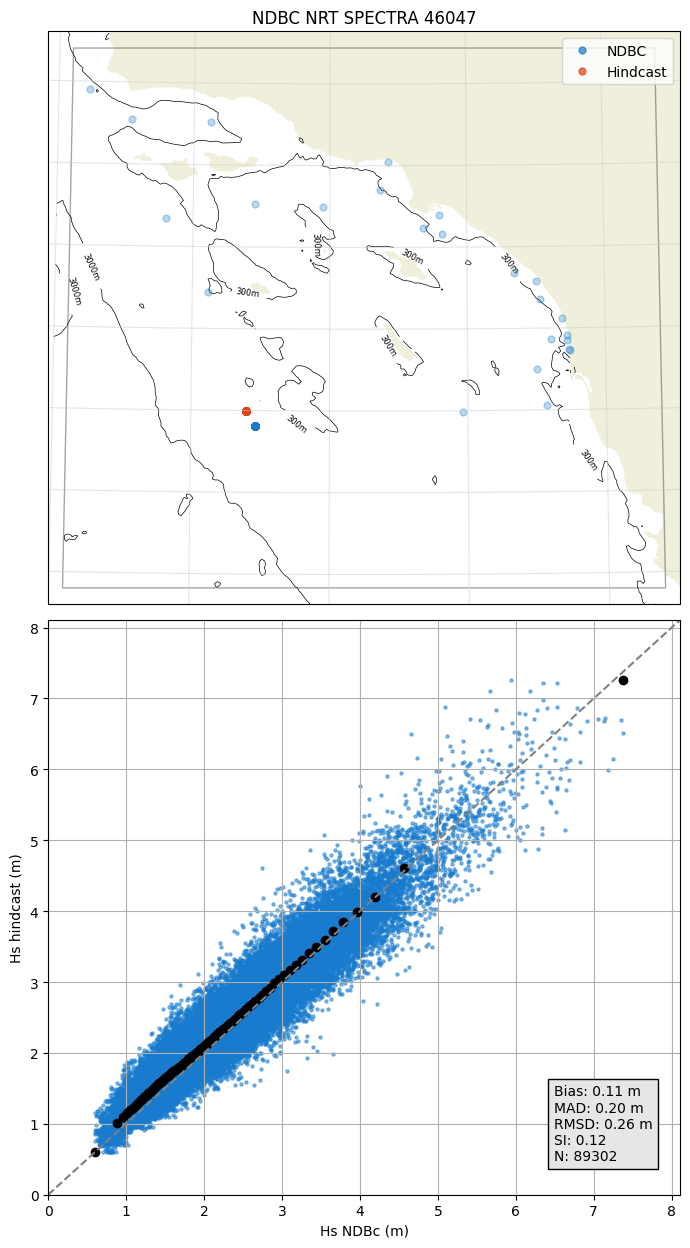

In [61]:
datasource = "ndbc_nrt_spectra_46047"
df = get_colocs(datasource)
print(df.index.min(), " -- ", df.index.max())
fig = plot_data(df, datasource)

#### Load satellite altimeter data within a 0.5-degree square centered at the site location

In [62]:
lon = float(df0.lon_obs.mean()) % 360
lat = float(df0.lat_obs.mean())
win = 0.25

query = dict(
    datasource="imos_wave_wind",
    variables=["swh_ku_cal", "swh_ku_quality_control", "platform"],
    geofilter={"type": "bbox", "geom":[lon-win, lat-win, lon+win, lat+win]}
)
dfsat = datamesh.query(query)
dfsat["longitude"] = dfsat.longitude - 360
display(dfsat.shape)
dfsat.head()

(13417, 7)

,time,longitude,latitude,swh_ku_cal,swh_ku_quality_control,platform,geometry
0,1991-12-15 18:48:34.562495,-119.29338,32.448660,1.308,1.0,ERS-1,POINT (240.70662 32.44866)
1,1991-12-15 18:48:35.546879,-119.30960,32.390820,1.448,1.0,ERS-1,POINT (240.69040 32.39082)
2,1991-12-15 18:48:36.531253,-119.32580,32.332977,1.378,1.0,ERS-1,POINT (240.67419 32.33298)
3,1991-12-15 18:48:37.499997,-119.34200,32.275130,1.390,1.0,ERS-1,POINT (240.65800 32.27513)
4,1991-12-15 18:48:38.484371,-119.35815,32.217300,1.390,1.0,ERS-1,POINT (240.64185 32.21730)


#### Keep only the "good" data (see https://www.nature.com/articles/s41597-019-0083-9)

In [65]:
dfsat = dfsat.loc[dfsat.swh_ku_quality_control == 1]
dfsat.shape

(12340, 7)

#### Map to show site and satellite passes

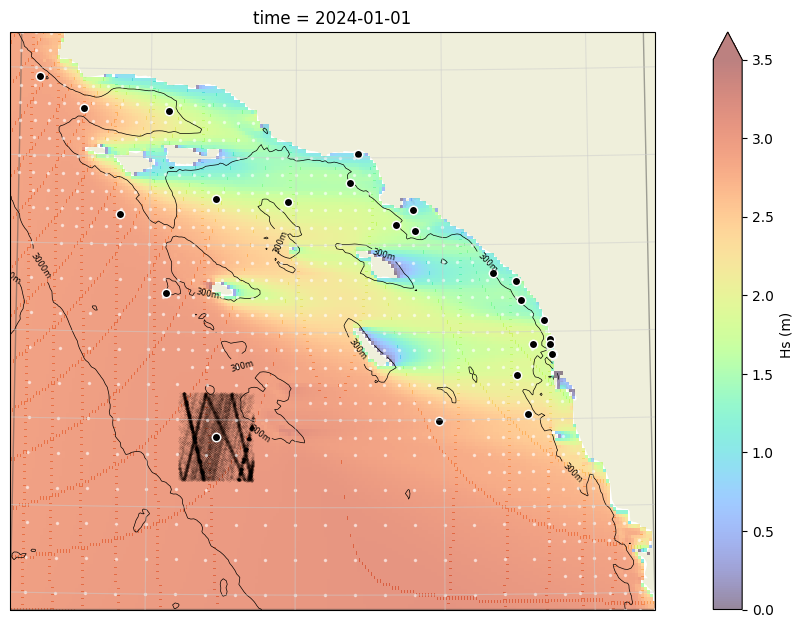

In [66]:
projection = ccrs.TransverseMercator(central_longitude=float(x1 + x0) / 2)

xbcali = [ds.geom.x for ds in datasources]
ybcali = [ds.geom.y for ds in datasources]

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))

# Show hindcast grid snapshot
cali.hs.plot(ax=ax, cmap="turbo", vmin=0, vmax=3.5, alpha=0.5, cbar_kwargs=dict(label="Hs (m)"), transform=TRANSFORM)
c = cali.depth.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=TRANSFORM)
c.clabel(fmt="%0.0fm", fontsize=6)

# Show satellite passes
ax.plot(dfsat.longitude, dfsat.latitude, ".k", markersize=0.2, alpha=0.5, transform=TRANSFORM)

# Show the hindcast spectra locations
ax.plot(coords.lon, coords.lat, ".", markersize=3, color="1.0", alpha=0.5, transform=TRANSFORM)

# Show the buoy locations
ax.plot(xb, yb, "wo", markerfacecolor="k", alpha=0.5, transform=TRANSFORM)
ax.plot(xbcali, ybcali, "wo", markerfacecolor="k", alpha=1.0, transform=TRANSFORM)

# Show the land mask
ax.add_feature(cfeature.LAND)

# Show spectra dataset bounds
geopandas.GeoSeries(ds_hds.geom).plot(ax=ax, facecolor="none", edgecolor="0.3", alpha=0.5, transform=TRANSFORM)

ax.set_extent([x0, x1, y0, y1])
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

#### Colocate the data

Interpolate hindcast at the satellite times

In [67]:
# Tidy up satellite dataframe
df = dfsat[["time", "swh_ku_cal", "longitude", "latitude", "platform"]].set_index("time")

# Interpolate model and obs at satellite times using xarray
ds = xr.Dataset.from_dataframe(df0)
df["swh_obs"] = ds.hs_obs.interp(time=df.index).to_pandas()
df["swh_hds"] = ds.hs_hds.interp(time=df.index).to_pandas()
df.tail()

,swh_ku_cal,longitude,latitude,platform,swh_obs,swh_hds
time,,,,,,
2020-12-15 12:30:13.999997,4.273,-119.41176,32.581757,SENTINEL-6A,4.053973,3.797367
2020-12-15 12:30:15.000002,3.928,-119.38553,32.534840,SENTINEL-6A,4.053885,3.797342
2020-12-15 12:30:15.999997,4.302,-119.35931,32.487915,SENTINEL-6A,4.053797,3.797317
2020-12-15 12:30:17.000001,4.202,-119.33315,32.440983,SENTINEL-6A,4.053709,3.797292
2020-12-15 12:30:17.999996,4.147,-119.30700,32.394043,SENTINEL-6A,4.053621,3.797266


#### Plot the data

In [86]:
def get_color_mapping(df, cmap="tab20"):
    """Get the colors and legend handles to make a scatter with satellite labels."""
    df["label"] = df.platform.str.strip()
    cm = plt.cm.get_cmap(cmap, df.label.unique().size)
    platform_to_color = {label: cm(i) for i, label in enumerate(df.label.unique())}
    colors = df["label"].map(platform_to_color)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=l) for l, c in platform_to_color.items()]
    return colors, legend_handles


def plot_satellite_scatter(df, x, y, ax, cmap="tab20"):
    """Plot scatter of satellite vs NDBC or hindcast colocations."""
    xlim = ylim = [0, 8]

    # Plot points
    colors, legend_handles = get_color_mapping(df, cmap)
    p = ax.scatter(df[x], df[y], s=5, c=colors, vmin=None, vmax=None, alpha=1.0)
    ax.legend(handles=legend_handles, title="Platform", fontsize=8)

    # Calculate and plot quantiles
    dfq = df[[x, y]].quantile(q=np.arange(0, 1.01, 0.01))
    ax.plot(dfq[x], dfq[y], "ok")

    # Equality line
    ax.plot(xlim, ylim, "--", color="0.5")

    # Show error statistics
    ax.annotate(errors(df, x, y), xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, color="0.0", bbox=dict(facecolor="0.9"))

    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Hs satellite (m)")
    yname = "NDBC" if "obs" in y else "hindcast"
    ax.set_ylabel(f"Hs {yname} (m)");

    return ax

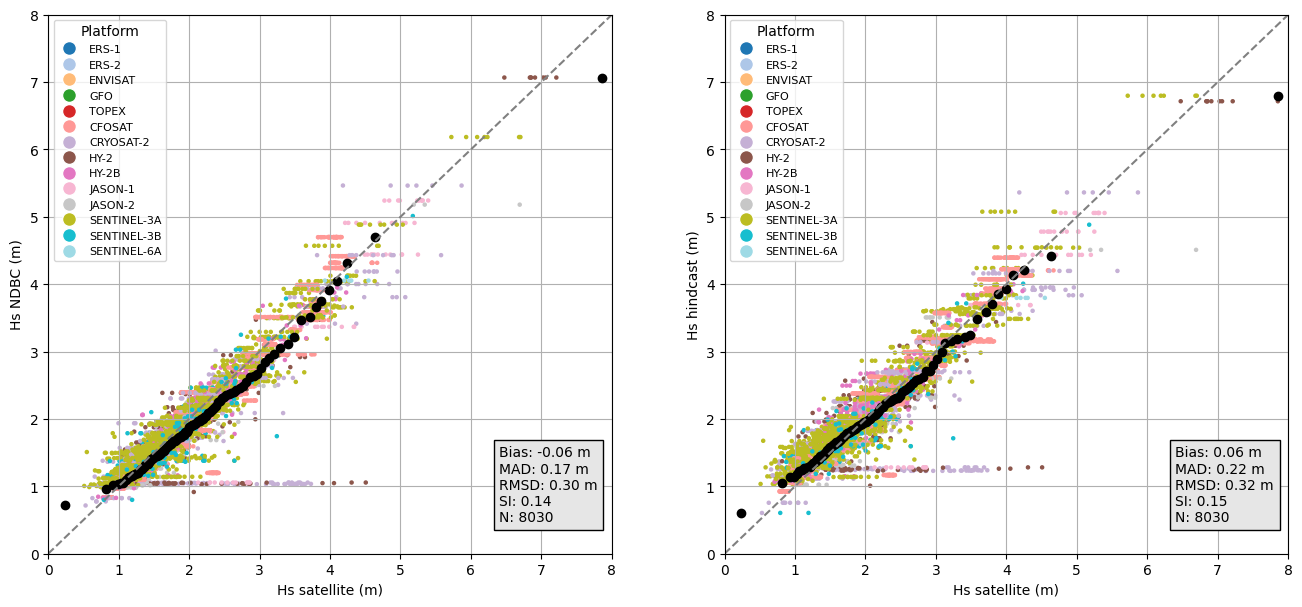

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Satellite vs NDBC
ax = plot_satellite_scatter(df, x="swh_ku_cal", y="swh_obs", ax=axs[0])

# Satellite vs NDBC
ax = plot_satellite_scatter(df, x="swh_ku_cal", y="swh_hds", ax=axs[1])